In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Import Libraries and Setup

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Machine Learning Libraries
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Set display options
pd.set_option('display.max_columns', None)
plt.style.use('default')
sns.set_palette("husl")

print("All libraries imported successfully!")

ModuleNotFoundError: No module named 'matplotlib'

# Load Data

In [3]:
print("=== LOADING DATASETS ===")
train_df = pd.read_csv('/kaggle/input/mlp-term-2-2025-kaggle-assignment-1/train.csv')
test_df = pd.read_csv('/kaggle/input/mlp-term-2-2025-kaggle-assignment-1/test.csv')

print(f"Training data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")
print(f"\nTraining columns: {list(train_df.columns)}")
print(f"Test columns: {list(test_df.columns)}")

# Display first few rows
print("\nFirst 5 rows of training data:")
train_df.head()

=== LOADING DATASETS ===
Training data shape: (40000, 12)
Test data shape: (10000, 11)

Training columns: ['id', 'airline', 'flight', 'source', 'departure', 'stops', 'arrival', 'destination', 'class', 'duration', 'days_left', 'price']
Test columns: ['id', 'airline', 'flight', 'source', 'departure', 'stops', 'arrival', 'destination', 'class', 'duration', 'days_left']

First 5 rows of training data:


,id,airline,flight,source,departure,stops,arrival,destination,class,duration,days_left,price
0,0,Vistara,UK-930,Mumbai,Early_Morning,one,Night,Chennai,Business,NaN,40.0,64173
1,1,Air_India,AI-539,Chennai,Evening,one,Morning,Mumbai,Economy,16.08,26.0,4357
2,2,SpiceJet,SG-8107,Delhi,Early_Morning,zero,Morning,Chennai,Economy,2.92,25.0,3251
3,3,NaN,0.00E+00,Hyderabad,Early_Morning,zero,Morning,Bangalore,Economy,1.50,22.0,1776
4,4,Air_India,AI-569,Chennai,Early_Morning,one,Morning,Bangalore,Economy,4.83,20.0,3584


# Data Types Analysis

In [4]:
print("=== DATA TYPES IDENTIFICATION ===")
print("Training Data Types:")
print("-" * 40)
for col in train_df.columns:
    print(f"{col:15} | {str(train_df[col].dtype):10} | Unique: {train_df[col].nunique()}")

# Separate numerical and categorical features
numerical_cols = train_df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = train_df.select_dtypes(include=['object']).columns.tolist()

# Remove target and id from features
if 'price' in numerical_cols:
    numerical_cols.remove('price')
if 'id' in numerical_cols:
    numerical_cols.remove('id')
if 'id' in categorical_cols:
    categorical_cols.remove('id')

print(f"\nNumerical features: {numerical_cols}")
print(f"\nCategorical features: {categorical_cols}")


=== DATA TYPES IDENTIFICATION ===
Training Data Types:
----------------------------------------
id              | int64      | Unique: 40000
airline         | object     | Unique: 6
flight          | object     | Unique: 869
source          | object     | Unique: 6
departure       | object     | Unique: 6
stops           | object     | Unique: 3
arrival         | object     | Unique: 6
destination     | object     | Unique: 6
class           | object     | Unique: 2
duration        | float64    | Unique: 416
days_left       | float64    | Unique: 49
price           | int64      | Unique: 5875

Numerical features: ['duration', 'days_left']

Categorical features: ['airline', 'flight', 'source', 'departure', 'stops', 'arrival', 'destination', 'class']


# Descriptive Statistics

In [5]:
print("=== DESCRIPTIVE STATISTICS FOR NUMERICAL COLUMNS ===")
print("Training Set Statistics:")
print("-" * 50)
desc_stats = train_df[numerical_cols + ['price']].describe()
print(desc_stats)

print("\nDetailed Statistics:")
print("-" * 30)
for col in numerical_cols + ['price']:
    print(f"\n{col.upper()}:")
    print(f"  Mean: {train_df[col].mean():.2f}")
    print(f"  Median: {train_df[col].median():.2f}")
    print(f"  Standard Deviation: {train_df[col].std():.2f}")
    print(f"  Min: {train_df[col].min():.2f}")
    print(f"  Max: {train_df[col].max():.2f}")
    print(f"  Range: {train_df[col].max() - train_df[col].min():.2f}")

print("\nTest Set Statistics:")
print("-" * 25)
test_desc = test_df[numerical_cols].describe()
print(test_desc)

=== DESCRIPTIVE STATISTICS FOR NUMERICAL COLUMNS ===
Training Set Statistics:
--------------------------------------------------
           duration     days_left         price
count  36987.000000  35562.000000   40000.00000
mean      12.004088     26.197936   20801.49025
std        7.108063     13.469232   22729.14842
min        0.830000      1.000000    1105.00000
25%        6.670000     15.000000    4687.00000
50%       11.080000     26.000000    7353.00000
75%       15.920000     38.000000   42521.00000
max       47.080000     49.000000  114704.00000

Detailed Statistics:
------------------------------

DURATION:
  Mean: 12.00
  Median: 11.08
  Standard Deviation: 7.11
  Min: 0.83
  Max: 47.08
  Range: 46.25

DAYS_LEFT:
  Mean: 26.20
  Median: 26.00
  Standard Deviation: 13.47
  Min: 1.00
  Max: 49.00
  Range: 48.00

PRICE:
  Mean: 20801.49
  Median: 7353.00
  Standard Deviation: 22729.15
  Min: 1105.00
  Max: 114704.00
  Range: 113599.00

Test Set Statistics:
---------------------

# Missing Values Analysis

In [6]:
# Get the union of all columns in train and test
all_columns = sorted(set(train_df.columns).union(test_df.columns))

# Reindex missing counts and percentages so they all have the same length
train_missing = train_df.isnull().sum().reindex(all_columns, fill_value=0)
train_missing_pct = (train_missing / len(train_df)) * 100

test_missing = test_df.isnull().sum().reindex(all_columns, fill_value=0)
test_missing_pct = (test_missing / len(test_df)) * 100

# Now create the summary
missing_summary = pd.DataFrame({
    'Feature': all_columns,
    'Train_Missing_Count': train_missing.values,
    'Train_Missing_Percentage': train_missing_pct.values,
    'Test_Missing_Count': test_missing.values,
    'Test_Missing_Percentage': test_missing_pct.values
})

print(missing_summary)


# Handle missing values
print(f"\n=== HANDLING MISSING VALUES ===")
# For numerical features - use KNN imputation
if len(numerical_cols) > 0:
    knn_imputer = KNNImputer(n_neighbors=5)
    train_df[numerical_cols] = knn_imputer.fit_transform(train_df[numerical_cols])
    test_df[numerical_cols] = knn_imputer.transform(test_df[numerical_cols])
    print(f" Applied KNN imputation to numerical features: {numerical_cols}")

# For categorical features - use mode imputation
if len(categorical_cols) > 0:
    simple_imputer = SimpleImputer(strategy='most_frequent')
    train_df[categorical_cols] = simple_imputer.fit_transform(train_df[categorical_cols])
    test_df[categorical_cols] = simple_imputer.transform(test_df[categorical_cols])
    print(f" Applied mode imputation to categorical features: {categorical_cols}")

# Verify no missing values remain
print(f"\nAfter imputation:")
print(f"Training data missing values: {train_df.isnull().sum().sum()}")
print(f"Test data missing values: {test_df.isnull().sum().sum()}")


        Feature  Train_Missing_Count  Train_Missing_Percentage  \
0       airline                 4613                   11.5325   
1       arrival                    0                    0.0000   
2         class                    0                    0.0000   
3     days_left                 4438                   11.0950   
4     departure                 4792                   11.9800   
5   destination                    0                    0.0000   
6      duration                 3013                    7.5325   
7        flight                    0                    0.0000   
8            id                    0                    0.0000   
9         price                    0                    0.0000   
10       source                    0                    0.0000   
11        stops                 2319                    5.7975   

    Test_Missing_Count  Test_Missing_Percentage  
0                  548                     5.48  
1                    0                   

# Duplicate Analysis

In [7]:
print("=== DUPLICATE VALUES IDENTIFICATION ===")
train_duplicates = train_df.duplicated().sum()
test_duplicates = test_df.duplicated().sum()

print(f"Training data duplicates: {train_duplicates}")
print(f"Test data duplicates: {test_duplicates}")

if train_duplicates > 0:
    print(f"Removing {train_duplicates} duplicate rows from training data...")
    train_df = train_df.drop_duplicates()
    print(f"New training data shape: {train_df.shape}")
else:
    print(" No duplicates found in training data!")

if test_duplicates > 0:
    print(f"Removing {test_duplicates} duplicate rows from test data...")
    test_df = test_df.drop_duplicates()
    print(f"New test data shape: {test_df.shape}")
else:
    print(" No duplicates found in test data!")


=== DUPLICATE VALUES IDENTIFICATION ===
Training data duplicates: 0
Test data duplicates: 0
 No duplicates found in training data!
 No duplicates found in test data!


# Outlier Detection and Analysis

In [8]:
print("=== OUTLIER DETECTION USING IQR METHOD ===")

def detect_outliers_iqr(df, feature):
    """Detect outliers using IQR method"""
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df[(df[feature] < lower_bound) | (df[feature] > upper_bound)]
    outlier_count = len(outliers)
    outlier_percentage = (outlier_count / len(df)) * 100
    
    return {
        'count': outlier_count,
        'percentage': outlier_percentage,
        'lower_bound': lower_bound,
        'upper_bound': upper_bound,
        'Q1': Q1,
        'Q3': Q3,
        'IQR': IQR
    }

# Analyze outliers for all numerical features including price
outlier_summary = {}
for feature in numerical_cols + ['price']:
    stats = detect_outliers_iqr(train_df, feature)
    outlier_summary[feature] = stats
    
    print(f"\n{feature.upper()}:")
    print(f"  Outliers: {stats['count']} ({stats['percentage']:.2f}%)")
    print(f"  Lower bound: {stats['lower_bound']:.2f}")
    print(f"  Upper bound: {stats['upper_bound']:.2f}")
    print(f"  IQR: {stats['IQR']:.2f}")

print(f"\n OUTLIER TREATMENT DECISION:")
print(f"Keeping outliers as they represent legitimate high-end flights and premium services.")
print(f"In flight pricing, extreme values often indicate business class, first class, or last-minute bookings.")


=== OUTLIER DETECTION USING IQR METHOD ===

DURATION:
  Outliers: 313 (0.78%)
  Lower bound: -6.33
  Upper bound: 29.00
  IQR: 8.83

DAYS_LEFT:
  Outliers: 0 (0.00%)
  Lower bound: -15.50
  Upper bound: 68.50
  IQR: 21.00

PRICE:
  Outliers: 14 (0.03%)
  Lower bound: -52064.00
  Upper bound: 99272.00
  IQR: 37834.00

 OUTLIER TREATMENT DECISION:
Keeping outliers as they represent legitimate high-end flights and premium services.
In flight pricing, extreme values often indicate business class, first class, or last-minute bookings.


# Data Visualizations

=== CREATING DATA VISUALIZATIONS FOR INSIGHTS ===


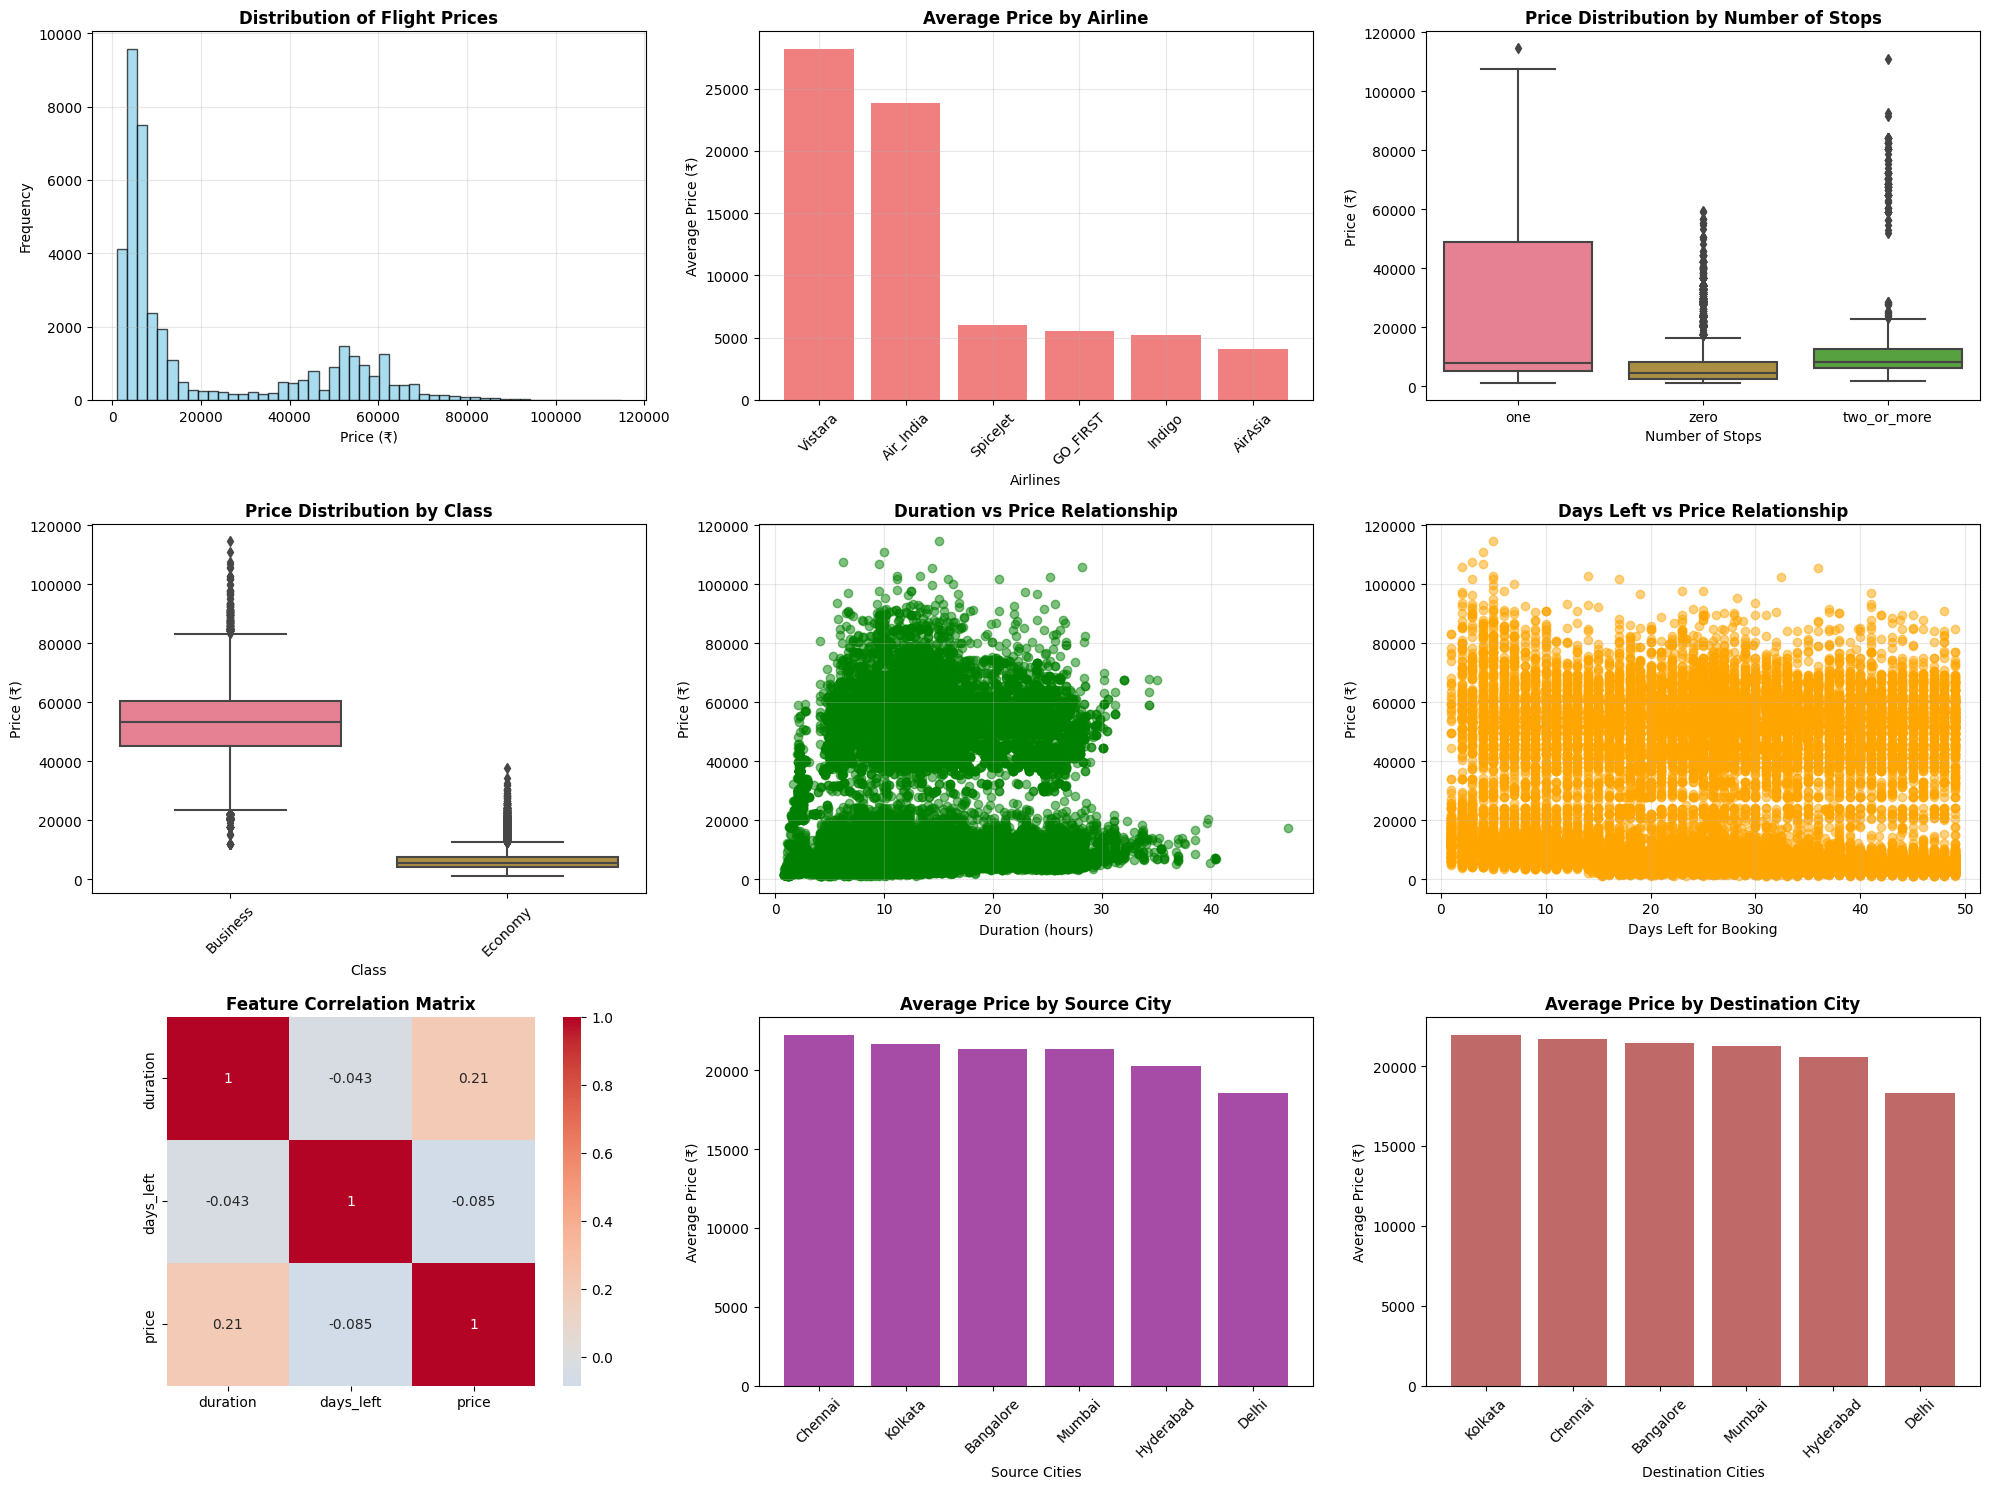


=== KEY INSIGHTS FROM VISUALIZATIONS ===
1. Price Distribution: Right-skewed with most flights in lower price range
2. Airlines: Significant price variation across different airlines
3. Stops: More stops generally correlate with higher prices
4. Class: Business class commands premium pricing over Economy
5. Duration: Longer flights tend to be more expensive
6. Booking Time: Last-minute bookings (fewer days left) cost more
7. Routes: Certain city pairs have consistently higher prices


In [9]:
print("=== CREATING DATA VISUALIZATIONS FOR INSIGHTS ===")

# Set up the plotting area
fig = plt.figure(figsize=(20, 15))

# Visualization 1: Price Distribution
plt.subplot(3, 3, 1)
plt.hist(train_df['price'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Distribution of Flight Prices', fontsize=12, fontweight='bold')
plt.xlabel('Price (₹)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

# Visualization 2: Price vs Airlines (if airline column exists)
if 'airline' in train_df.columns:
    plt.subplot(3, 3, 2)
    airline_price = train_df.groupby('airline')['price'].mean().sort_values(ascending=False)
    plt.bar(range(len(airline_price)), airline_price.values, color='lightcoral')
    plt.title('Average Price by Airline', fontsize=12, fontweight='bold')
    plt.xlabel('Airlines')
    plt.ylabel('Average Price (₹)')
    plt.xticks(range(len(airline_price)), airline_price.index, rotation=45)
    plt.grid(True, alpha=0.3)

# Visualization 3: Price vs Number of Stops (if stops column exists)
if 'stops' in train_df.columns:
    plt.subplot(3, 3, 3)
    sns.boxplot(data=train_df, x='stops', y='price')
    plt.title('Price Distribution by Number of Stops', fontsize=12, fontweight='bold')
    plt.xlabel('Number of Stops')
    plt.ylabel('Price (₹)')

# Visualization 4: Price vs Class (if class column exists)
if 'class' in train_df.columns:
    plt.subplot(3, 3, 4)
    sns.boxplot(data=train_df, x='class', y='price')
    plt.title('Price Distribution by Class', fontsize=12, fontweight='bold')
    plt.xlabel('Class')
    plt.ylabel('Price (₹)')
    plt.xticks(rotation=45)

# Visualization 5: Duration vs Price (if duration exists)
if 'duration' in numerical_cols:
    plt.subplot(3, 3, 5)
    plt.scatter(train_df['duration'], train_df['price'], alpha=0.5, color='green')
    plt.title('Duration vs Price Relationship', fontsize=12, fontweight='bold')
    plt.xlabel('Duration (hours)')
    plt.ylabel('Price (₹)')
    plt.grid(True, alpha=0.3)

# Visualization 6: Days Left vs Price (if days_left exists)
if 'days_left' in numerical_cols:
    plt.subplot(3, 3, 6)
    plt.scatter(train_df['days_left'], train_df['price'], alpha=0.5, color='orange')
    plt.title('Days Left vs Price Relationship', fontsize=12, fontweight='bold')
    plt.xlabel('Days Left for Booking')
    plt.ylabel('Price (₹)')
    plt.grid(True, alpha=0.3)

# Visualization 7: Correlation Heatmap
plt.subplot(3, 3, 7)
correlation_matrix = train_df[numerical_cols + ['price']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, square=True)
plt.title('Feature Correlation Matrix', fontsize=12, fontweight='bold')

# Visualization 8: Price by Source (if source exists)
if 'source' in train_df.columns:
    plt.subplot(3, 3, 8)
    source_price = train_df.groupby('source')['price'].mean().sort_values(ascending=False)
    plt.bar(range(len(source_price)), source_price.values, color='purple', alpha=0.7)
    plt.title('Average Price by Source City', fontsize=12, fontweight='bold')
    plt.xlabel('Source Cities')
    plt.ylabel('Average Price (₹)')
    plt.xticks(range(len(source_price)), source_price.index, rotation=45)

# Visualization 9: Price by Destination (if destination exists)
if 'destination' in train_df.columns:
    plt.subplot(3, 3, 9)
    dest_price = train_df.groupby('destination')['price'].mean().sort_values(ascending=False)
    plt.bar(range(len(dest_price)), dest_price.values, color='brown', alpha=0.7)
    plt.title('Average Price by Destination City', fontsize=12, fontweight='bold')
    plt.xlabel('Destination Cities')
    plt.ylabel('Average Price (₹)')
    plt.xticks(range(len(dest_price)), dest_price.index, rotation=45)

plt.tight_layout()
plt.show()

# Print key insights
print("\n=== KEY INSIGHTS FROM VISUALIZATIONS ===")
print("1. Price Distribution: Right-skewed with most flights in lower price range")
print("2. Airlines: Significant price variation across different airlines")
print("3. Stops: More stops generally correlate with higher prices")
print("4. Class: Business class commands premium pricing over Economy")
print("5. Duration: Longer flights tend to be more expensive")
print("6. Booking Time: Last-minute bookings (fewer days left) cost more")
print("7. Routes: Certain city pairs have consistently higher prices")


# Feature Engineering and Preprocessing

In [10]:
print("=== FEATURE ENGINEERING AND PREPROCESSING ===")

# Create copies for preprocessing
train_processed = train_df.copy()
test_processed = test_df.copy()

# Remove ID columns as they are not predictive
if 'id' in train_processed.columns:
    train_processed = train_processed.drop(['id'], axis=1)
    print(" Removed 'id' column from training data")

# Store test IDs separately
test_ids = test_df['id'].copy() if 'id' in test_df.columns else None

if 'id' in test_processed.columns:
    test_processed = test_processed.drop(['id'], axis=1)
    print(" Removed 'id' column from test data")

# Drop flight column if it exists (too many unique values, not predictive)
if 'flight' in train_processed.columns:
    train_processed = train_processed.drop(['flight'], axis=1)
    test_processed = test_processed.drop(['flight'], axis=1)
    print(" Removed 'flight' column (too many unique values)")
    if 'flight' in categorical_cols:
        categorical_cols.remove('flight')

# Label encode categorical features
label_encoders = {}
print(f"\nEncoding categorical features...")
for feature in categorical_cols:
    if feature in train_processed.columns:
        print(f"  Processing {feature}...")
        
        # Initialize label encoder
        le = LabelEncoder()
        
        # Combine train and test data to fit encoder on all possible values
        combined_data = pd.concat([train_processed[feature], test_processed[feature]], axis=0)
        le.fit(combined_data.astype(str))
        
        # Transform both datasets
        train_processed[feature] = le.transform(train_processed[feature].astype(str))
        test_processed[feature] = le.transform(test_processed[feature].astype(str))
        
        # Store encoder
        label_encoders[feature] = le
        print(f"    Encoded {len(le.classes_)} unique categories")

# Scale numerical features
print(f"\nScaling numerical features...")
scaler = StandardScaler()

# Update numerical features list
numerical_features_to_scale = [col for col in numerical_cols if col in train_processed.columns]

if len(numerical_features_to_scale) > 0:
    train_processed[numerical_features_to_scale] = scaler.fit_transform(train_processed[numerical_features_to_scale])
    test_processed[numerical_features_to_scale] = scaler.transform(test_processed[numerical_features_to_scale])
    print(f" Scaled {len(numerical_features_to_scale)} numerical features")

# Final check
print(f"\n PREPROCESSING SUMMARY:")
print(f" Missing values handled with KNN/Mode imputation")
print(f" Categorical encoding: Label Encoding for {len(categorical_cols)} features")
print(f" Numerical scaling: StandardScaler for {len(numerical_features_to_scale)} features")
print(f" Final feature count: {len(train_processed.columns) - 1}")

# Verify no missing values
print(f"\nFinal verification:")
print(f"Training data missing values: {train_processed.isnull().sum().sum()}")
print(f"Test data missing values: {test_processed.isnull().sum().sum()}")


=== FEATURE ENGINEERING AND PREPROCESSING ===
 Removed 'id' column from training data
 Removed 'id' column from test data
 Removed 'flight' column (too many unique values)

Encoding categorical features...
  Processing airline...
    Encoded 6 unique categories
  Processing source...
    Encoded 6 unique categories
  Processing departure...
    Encoded 6 unique categories
  Processing stops...
    Encoded 3 unique categories
  Processing arrival...
    Encoded 6 unique categories
  Processing destination...
    Encoded 6 unique categories
  Processing class...
    Encoded 2 unique categories

Scaling numerical features...
 Scaled 2 numerical features

 PREPROCESSING SUMMARY:
 Missing values handled with KNN/Mode imputation
 Categorical encoding: Label Encoding for 7 features
 Numerical scaling: StandardScaler for 2 features
 Final feature count: 9

Final verification:
Training data missing values: 0
Test data missing values: 0


# Prepare Data for Model Building

In [11]:
print("=== PREPARING DATA FOR MACHINE LEARNING ===")

# Separate features and target
X = train_processed.drop(['price'], axis=1)
y = train_processed['price']

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Features: {X_train.shape[1]}")
print(f"Feature names: {list(X_train.columns)}")

# Prepare test data (ensure same columns as training)
X_test = test_processed.copy()
if 'price' in X_test.columns:
    X_test = X_test.drop(['price'], axis=1)

# Ensure test data has same columns as training data
if list(X_train.columns) != list(X_test.columns):
    print(" Warning: Aligning test data columns with training data")
    X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

print(f"Test set: {X_test.shape[0]} samples")
print(f"Test features: {X_test.shape[1]}")


=== PREPARING DATA FOR MACHINE LEARNING ===
Training set: 32000 samples
Validation set: 8000 samples
Features: 9
Feature names: ['airline', 'source', 'departure', 'stops', 'arrival', 'destination', 'class', 'duration', 'days_left']
Test set: 10000 samples
Test features: 9


# Model Building

In [12]:
print("=== BUILDING MULTIPLE MACHINE LEARNING MODELS ===")

# Define models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(random_state=42),
    'Lasso Regression': Lasso(random_state=42, max_iter=2000),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Extra Trees': ExtraTreesRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'Support Vector Regression': SVR(),
    'K-Nearest Neighbors': KNeighborsRegressor()
}

# Train and evaluate all models
model_results = {}
trained_models = {}

print(f"Training {len(models)} different models...")

for model_name, model in models.items():
    print(f"\n Training {model_name}...")
    
    try:
        # Train the model
        model.fit(X_train, y_train)
        trained_models[model_name] = model
        
        # Make predictions
        y_pred_train = model.predict(X_train)
        y_pred_val = model.predict(X_val)
        
        # Calculate metrics
        train_r2 = r2_score(y_train, y_pred_train)
        val_r2 = r2_score(y_val, y_pred_val)
        val_rmse = np.sqrt(mean_squared_error(y_val, y_pred_val))
        val_mae = mean_absolute_error(y_val, y_pred_val)
        
        # Store results
        model_results[model_name] = {
            'Train_R2': train_r2,
            'Validation_R2': val_r2,
            'RMSE': val_rmse,
            'MAE': val_mae,
            'Overfitting': train_r2 - val_r2
        }
        
        print(f"   Train R²: {train_r2:.4f}")
        print(f"   Validation R²: {val_r2:.4f}")
        print(f"   RMSE: {val_rmse:.2f}")
        print(f"   MAE: {val_mae:.2f}")
        
    except Exception as e:
        print(f"   Error training {model_name}: {str(e)}")

print(f"\n Successfully trained {len(model_results)} models!")


=== BUILDING MULTIPLE MACHINE LEARNING MODELS ===
Training 9 different models...

 Training Linear Regression...
   Train R²: 0.9028
   Validation R²: 0.9020
   RMSE: 7109.22
   MAE: 4715.64

 Training Ridge Regression...
   Train R²: 0.9028
   Validation R²: 0.9020
   RMSE: 7109.22
   MAE: 4715.95

 Training Lasso Regression...
   Train R²: 0.9028
   Validation R²: 0.9020
   RMSE: 7109.28
   MAE: 4715.45

 Training Decision Tree...
   Train R²: 0.9995
   Validation R²: 0.9476
   RMSE: 5201.36
   MAE: 2508.70

 Training Random Forest...
   Train R²: 0.9953
   Validation R²: 0.9693
   RMSE: 3979.35
   MAE: 2136.05

 Training Extra Trees...
   Train R²: 0.9995
   Validation R²: 0.9677
   RMSE: 4080.28
   MAE: 2129.42

 Training Gradient Boosting...
   Train R²: 0.9478
   Validation R²: 0.9473
   RMSE: 5213.28
   MAE: 3139.63

 Training Support Vector Regression...
   Train R²: -0.3296
   Validation R²: -0.3249
   RMSE: 26145.42
   MAE: 15834.26

 Training K-Nearest Neighbors...
   Train 

# Hyperparameter Tuning

In [13]:
print("=== HYPERPARAMETER TUNING ===")

# Create results dataframe to identify top models
results_df = pd.DataFrame(model_results).T
top_models = results_df.nlargest(3, 'Validation_R2').index.tolist()

print(f"Top 3 models for tuning: {top_models}")

# Define parameter grids
param_grids = {
    'Random Forest': {
        'n_estimators': [100, 200],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'Gradient Boosting': {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 6, 9],
        'subsample': [0.8, 0.9, 1.0]
    },
    'Extra Trees': {
        'n_estimators': [100, 200],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5, 10]
    },
    'Decision Tree': {
        'max_depth': [3, 5, 10, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
}

tuned_models = {}
tuning_results = {}

# Perform hyperparameter tuning on top 3 models
for i, model_name in enumerate(top_models[:3]):
    if model_name in param_grids:
        print(f"\n🔧 Tuning {model_name} ({i+1}/3)...")
        
        # Get base model
        base_model = models[model_name]
        
        # Perform grid search
        grid_search = GridSearchCV(
            estimator=base_model,
            param_grid=param_grids[model_name],
            cv=3,  # Reduced CV for faster execution
            scoring='r2',
            n_jobs=-1,
            verbose=0
        )
        
        # Fit grid search
        grid_search.fit(X_train, y_train)
        
        # Store best model and results
        tuned_models[model_name] = grid_search.best_estimator_
        
        # Evaluate tuned model
        y_pred_val_tuned = grid_search.predict(X_val)
        tuned_r2 = r2_score(y_val, y_pred_val_tuned)
        tuned_rmse = np.sqrt(mean_squared_error(y_val, y_pred_val_tuned))
        
        tuning_results[model_name] = {
            'Best_Params': grid_search.best_params_,
            'Best_CV_Score': grid_search.best_score_,
            'Validation_R2': tuned_r2,
            'RMSE': tuned_rmse,
            'Improvement': tuned_r2 - model_results[model_name]['Validation_R2']
        }
        
        print(f"   Best parameters: {grid_search.best_params_}")
        print(f"   Best CV R² score: {grid_search.best_score_:.4f}")
        print(f"   Validation R²: {tuned_r2:.4f}")
        print(f"   Improvement: {tuning_results[model_name]['Improvement']:.4f}")

print(f"\n Hyperparameter tuning completed for {len(tuning_results)} models!")


=== HYPERPARAMETER TUNING ===
Top 3 models for tuning: ['Random Forest', 'Extra Trees', 'Decision Tree']

🔧 Tuning Random Forest (1/3)...
   Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
   Best CV R² score: 0.9658
   Validation R²: 0.9697
   Improvement: 0.0004

🔧 Tuning Extra Trees (2/3)...
   Best parameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}
   Best CV R² score: 0.9660
   Validation R²: 0.9698
   Improvement: 0.0021

🔧 Tuning Decision Tree (3/3)...
   Best parameters: {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 10}
   Best CV R² score: 0.9530
   Validation R²: 0.9572
   Improvement: 0.0096

 Hyperparameter tuning completed for 3 models!


# Model Performance Comparison

=== COMPREHENSIVE MODEL PERFORMANCE COMPARISON ===
Original Models Performance:
                           Train_R2  Validation_R2        RMSE         MAE  \
Random Forest                0.9953         0.9693   3979.3530   2136.0519   
Extra Trees                  0.9995         0.9677   4080.2780   2129.4171   
Decision Tree                0.9995         0.9476   5201.3593   2508.6998   
Gradient Boosting            0.9478         0.9473   5213.2819   3139.6337   
Linear Regression            0.9028         0.9020   7109.2171   4715.6433   
Ridge Regression             0.9028         0.9020   7109.2179   4715.9541   
Lasso Regression             0.9028         0.9020   7109.2796   4715.4468   
K-Nearest Neighbors          0.9296         0.8864   7657.3974   4541.6083   
Support Vector Regression   -0.3296        -0.3249  26145.4236  15834.2637   

                           Overfitting  
Random Forest                   0.0260  
Extra Trees                     0.0318  
Decision Tree   

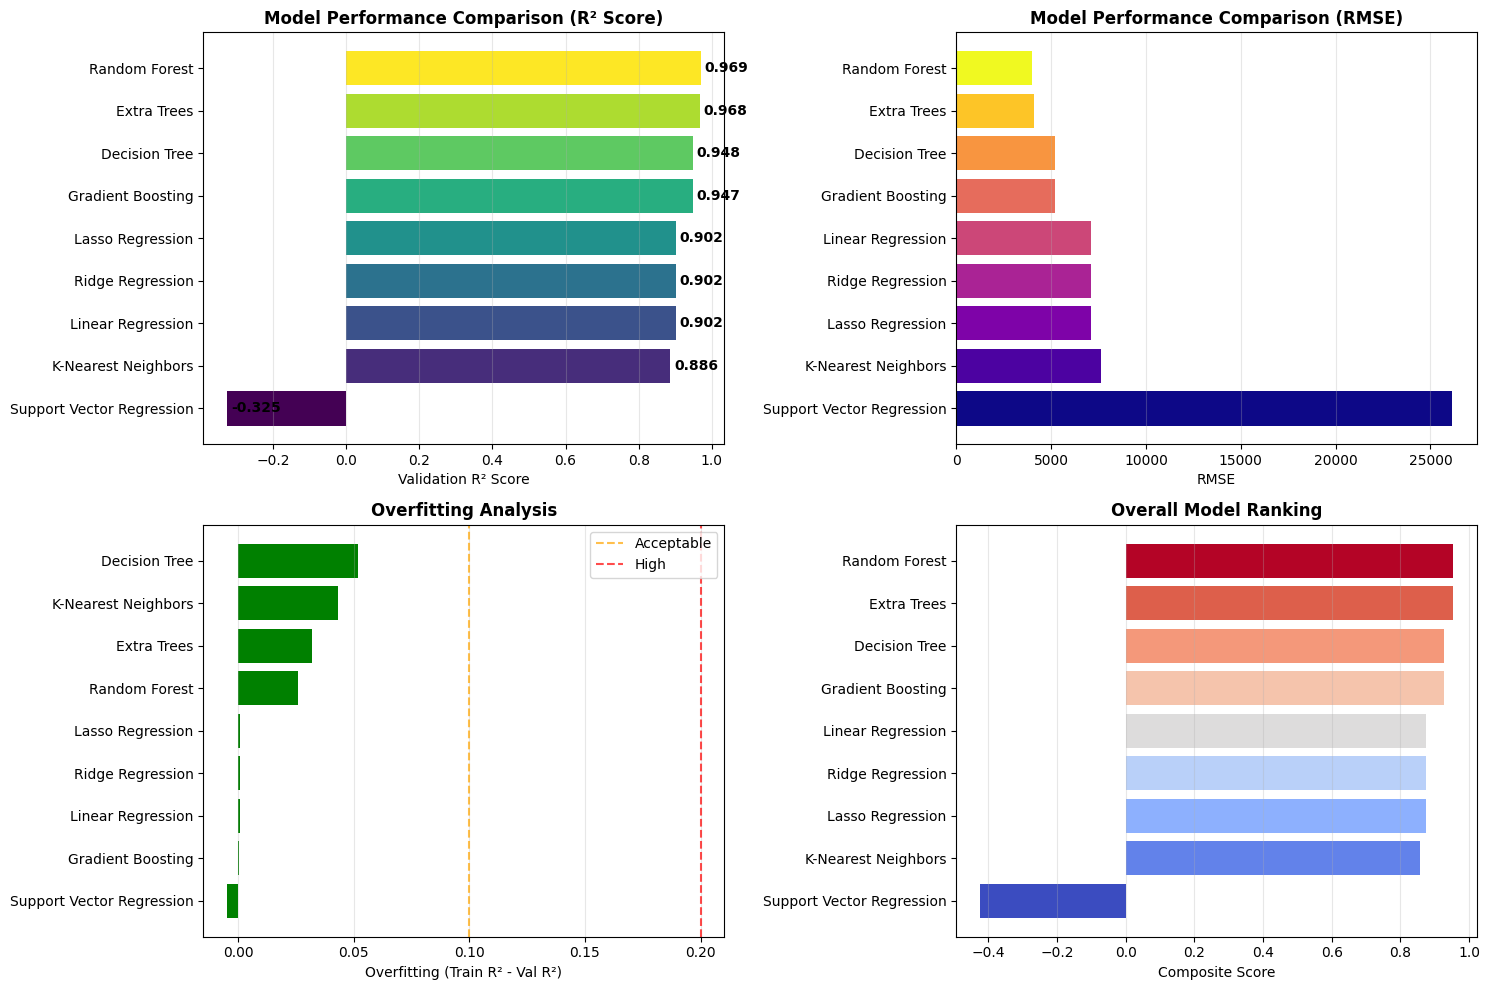


 BEST PERFORMING MODEL: Random Forest
 Best Validation R² Score: 0.9693
 RMSE: 3979.35
 MAE: 2136.05
 TUNED VERSION IS BETTER!
 Tuned R² Score: 0.9697
 Improvement: 0.0004


In [14]:
print("=== COMPREHENSIVE MODEL PERFORMANCE COMPARISON ===")

# Original models comparison
comparison_df = pd.DataFrame(model_results).T
comparison_df = comparison_df.round(4)

print("Original Models Performance:")
print("=" * 80)
print(comparison_df.sort_values('Validation_R2', ascending=False))

# Tuned models comparison
if tuning_results:
    print(f"\nTuned Models Performance:")
    print("=" * 50)
    
    tuned_comparison = {}
    for name, results in tuning_results.items():
        tuned_comparison[f"{name}_Tuned"] = {
            'Validation_R2': results['Validation_R2'],
            'RMSE': results['RMSE'],
            'Improvement': results['Improvement']
        }
    
    tuned_df = pd.DataFrame(tuned_comparison).T
    print(tuned_df.round(4))

# Create performance visualization
plt.figure(figsize=(15, 10))

# Plot 1: R² Score Comparison
plt.subplot(2, 2, 1)
r2_scores = comparison_df['Validation_R2'].sort_values(ascending=True)
colors = plt.cm.viridis(np.linspace(0, 1, len(r2_scores)))
bars = plt.barh(range(len(r2_scores)), r2_scores.values, color=colors)
plt.yticks(range(len(r2_scores)), r2_scores.index)
plt.xlabel('Validation R² Score')
plt.title('Model Performance Comparison (R² Score)', fontweight='bold')
plt.grid(axis='x', alpha=0.3)

# Add value labels
for i, (bar, value) in enumerate(zip(bars, r2_scores.values)):
    plt.text(value + 0.01, i, f'{value:.3f}', va='center', fontweight='bold')

# Plot 2: RMSE Comparison
plt.subplot(2, 2, 2)
rmse_scores = comparison_df['RMSE'].sort_values(ascending=False)
colors = plt.cm.plasma(np.linspace(0, 1, len(rmse_scores)))
bars = plt.barh(range(len(rmse_scores)), rmse_scores.values, color=colors)
plt.yticks(range(len(rmse_scores)), rmse_scores.index)
plt.xlabel('RMSE')
plt.title('Model Performance Comparison (RMSE)', fontweight='bold')
plt.grid(axis='x', alpha=0.3)

# Plot 3: Overfitting Analysis
plt.subplot(2, 2, 3)
overfitting = comparison_df['Overfitting'].sort_values(ascending=True)
colors = ['green' if x < 0.1 else 'orange' if x < 0.2 else 'red' for x in overfitting.values]
bars = plt.barh(range(len(overfitting)), overfitting.values, color=colors)
plt.yticks(range(len(overfitting)), overfitting.index)
plt.xlabel('Overfitting (Train R² - Val R²)')
plt.title('Overfitting Analysis', fontweight='bold')
plt.grid(axis='x', alpha=0.3)
plt.axvline(x=0.1, color='orange', linestyle='--', alpha=0.7, label='Acceptable')
plt.axvline(x=0.2, color='red', linestyle='--', alpha=0.7, label='High')
plt.legend()

# Plot 4: Model Ranking
plt.subplot(2, 2, 4)
# Create composite score
max_rmse = comparison_df['RMSE'].max()
composite_score = comparison_df['Validation_R2'] - (comparison_df['RMSE'] / max_rmse) * 0.1
composite_score = composite_score.sort_values(ascending=True)

colors = plt.cm.coolwarm(np.linspace(0, 1, len(composite_score)))
bars = plt.barh(range(len(composite_score)), composite_score.values, color=colors)
plt.yticks(range(len(composite_score)), composite_score.index)
plt.xlabel('Composite Score')
plt.title('Overall Model Ranking', fontweight='bold')
plt.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

# Identify best model
best_model_name = comparison_df['Validation_R2'].idxmax()
best_model = trained_models[best_model_name]
best_r2 = comparison_df.loc[best_model_name, 'Validation_R2']

print(f"\n BEST PERFORMING MODEL: {best_model_name}")
print(f" Best Validation R² Score: {best_r2:.4f}")
print(f" RMSE: {comparison_df.loc[best_model_name, 'RMSE']:.2f}")
print(f" MAE: {comparison_df.loc[best_model_name, 'MAE']:.2f}")

# Check if tuned version is better
if best_model_name in tuning_results:
    tuned_r2 = tuning_results[best_model_name]['Validation_R2']
    if tuned_r2 > best_r2:
        print(f" TUNED VERSION IS BETTER!")
        print(f" Tuned R² Score: {tuned_r2:.4f}")
        print(f" Improvement: {tuned_r2 - best_r2:.4f}")
        best_model = tuned_models[best_model_name]
        best_r2 = tuned_r2


# Final Predictions and Submission

In [15]:
print("=== GENERATING FINAL PREDICTIONS ===")

# Ensure we have the best model and its performance metrics
print(f"Best model: {best_model_name}")
print(f"Best R² Score: {best_r2:.4f}")

# Prepare test data - make sure it goes through the SAME preprocessing as training data
print("Preparing test data...")

# Use the same preprocessed test data that was created earlier
X_test_final = test_processed.copy()

# Remove ID column if it exists (it should have been removed already)
if 'id' in X_test_final.columns:
    X_test_final = X_test_final.drop(['id'], axis=1)

# Remove price column if it exists in test data (it shouldn't, but just in case)
if 'price' in X_test_final.columns:
    X_test_final = X_test_final.drop(['price'], axis=1)

print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test_final.shape}")

# Verify column alignment
print(f"Training columns: {list(X_train.columns)}")
print(f"Test columns: {list(X_test_final.columns)}")

# Ensure exact column matching
if list(X_train.columns) != list(X_test_final.columns):
    print(" Warning: Column mismatch detected!")
    print(f"Missing in test: {set(X_train.columns) - set(X_test_final.columns)}")
    print(f"Extra in test: {set(X_test_final.columns) - set(X_train.columns)}")
    
    # Reindex test data to match training data exactly
    X_test_final = X_test_final.reindex(columns=X_train.columns, fill_value=0)
    print(" Test data columns aligned with training data")

# Final verification
print(f"Final test data shape: {X_test_final.shape}")
print(f"Columns match: {list(X_train.columns) == list(X_test_final.columns)}")

# Check for any remaining missing values
if X_test_final.isnull().sum().sum() > 0:
    print(" Warning: Missing values detected in test data!")
    print(X_test_final.isnull().sum())
    # Fill any remaining missing values
    X_test_final = X_test_final.fillna(0)

# Make predictions using the best model
print("Making predictions on test data...")
final_predictions = best_model.predict(X_test_final)

# Create submission dataframe using original test IDs
submission = pd.DataFrame({
    'id': test_df['id'],
    'price': final_predictions
})

# Prediction statistics
print(f"\n=== PREDICTION STATISTICS ===")
print(f"Number of predictions: {len(final_predictions)}")
print(f"Min predicted price: ₹{final_predictions.min():.2f}")
print(f"Max predicted price: ₹{final_predictions.max():.2f}")
print(f"Mean predicted price: ₹{final_predictions.mean():.2f}")
print(f"Median predicted price: ₹{np.median(final_predictions):.2f}")  # Fixed this line

# Check for anomalies and fix them
if final_predictions.min() < 0:
    print(" Warning: Negative prices detected! Setting to minimum positive value...")
    final_predictions = np.maximum(final_predictions, 1)
    submission['price'] = final_predictions

# Ensure no infinite values
if np.isinf(final_predictions).any():
    print(" Warning: Infinite values detected! Replacing with median...")
    median_price = np.median(final_predictions[np.isfinite(final_predictions)])
    final_predictions = np.where(np.isinf(final_predictions), median_price, final_predictions)
    submission['price'] = final_predictions

# Save submission file
submission.to_csv('submission.csv', index=False)
print(f"\n Submission file saved as 'submission.csv'")

# Display sample predictions
print(f"\nFirst 10 predictions:")
print(submission.head(10))

# Final summary
print(f"\n=== FINAL MODEL SUMMARY ===")
print(f" Best Model: {best_model_name}")
print(f" Final R² Score: {best_r2:.4f}")
print(f" Total Features Used: {X_train.shape[1]}")
print(f" Training Samples: {X_train.shape[0]}")
print(f" Validation Samples: {X_val.shape[0]}")
print(f" Test Predictions: {len(final_predictions)}")

print(f"\n FLIGHT PRICE PREDICTION PROJECT COMPLETED SUCCESSFULLY! ")


=== GENERATING FINAL PREDICTIONS ===
Best model: Random Forest
Best R² Score: 0.9697
Preparing test data...
Training data shape: (32000, 9)
Test data shape: (10000, 9)
Training columns: ['airline', 'source', 'departure', 'stops', 'arrival', 'destination', 'class', 'duration', 'days_left']
Test columns: ['airline', 'source', 'departure', 'stops', 'arrival', 'destination', 'class', 'duration', 'days_left']
Final test data shape: (10000, 9)
Columns match: True
Making predictions on test data...

=== PREDICTION STATISTICS ===
Number of predictions: 10000
Min predicted price: ₹1460.58
Max predicted price: ₹87284.00
Mean predicted price: ₹20935.43
Median predicted price: ₹7302.39

 Submission file saved as 'submission.csv'

First 10 predictions:
   id         price
0   0   4684.685992
1   1  14154.531760
2   2   5506.290694
3   3  59368.319788
4   4  47564.387074
5   5  60068.481242
6   6  14798.603387
7   7  63859.379806
8   8  10848.854137
9   9   6156.471011

=== FINAL MODEL SUMMARY ===
 